# To-do List
- fwhm doesn't account for slopped baseline
    - need to cut out the transit and fit a line to the baseline
    - then subtract this from the full observation
- generalize the code to work with a class structure (c.f. dedispersion)
    - match the colours of the plots to the standard colours
        - e.g. pink and red for E, cyan and blue for W
        - may need to change how the horn if statement works
- plot H1 powers
    - need a way to easily enter ONE date and it give you the H1 and total powers
    - then need to SEPERATELY calculate the FWHM for each to compare
    - HI power plots show very similar beam width to the total power
- convert from FWHM to true beam width
    - mostly done but still unsure about 3D geometry
    - also need to confirm the 1e6 correction
- if I now work with ALL freq channel then can reuse dedispersion code
    - very complex data structure
        - i think it follows as [4,420,718] --> 4 outputs, 420 measurements, 718 freq channels
        - not sure how to use this though
    - ***THIS IS A PRIORITY!!!***
- try removing the interferometry effect using an ifft
- ***THE UNCERTAINTY ON THE MEAN IS WRONG!!!***
    - not sure what to do for this???

# (0) Set-up

In [1]:
import os
import numpy as np

from scipy import interpolate
import scipy

import datetime

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.coordinates import Angle

from matplotlib import pyplot as plt
from math import pi

In [2]:
pathtemplate = "C:/Users/jetso/Creative Cloud Files/Desktop/Uni/L-BASS"

filelist = []
for (dirpath, dirnames, filenames) in os.walk(pathtemplate):
    filelist.extend(filenames)
    break
print (filelist)

['accom1.PNG', 'accom2.PNG', 'L_BASS_first_paper_version_2(5).pdf', 'solar_transit.ipynb', 'solar_transit_21_03_22.csv', 'travel.PNG', 'work_experience_proof.PNG']


# (1) Import Data
- Will first try with the 2022 data to compare to excel results
  - only using 18 Mar data but should **generalise the method into functions to work for any data**
- Then repeat with 2024 observation

## (1.1) Total and HI Powers

I use a class system here to make it easier to quickly view data.
I have a new form of data though and need to make it work again:
- I have folders for each date
- in each folder are 5 npy arrays
  - 4 spectrometer outputs
  - 1 for the datetime objects

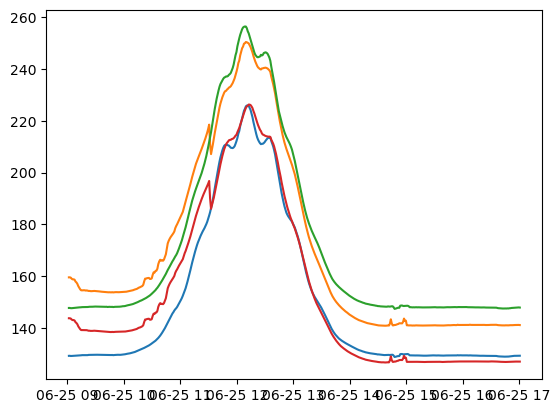

In [3]:
# creates a class object for each transit
# object will store the date and solar declination for each transit
# using get_data(), an array for the transit can be obtained
class Transit_total:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
    def get_data(self):
        folder = os.path.join(pathtemplate,f"Data/{transit_total.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        R0W = np.load(os.path.join(folder, 'R0W_powers.npy'), allow_pickle=True)
        L0E = np.load(os.path.join(folder, 'L0E_powers.npy'), allow_pickle=True)
        LpiW = np.load(os.path.join(folder, 'LpiW_powers.npy'), allow_pickle=True)
        RpiE = np.load(os.path.join(folder, 'RpiE_powers.npy'), allow_pickle=True)
        if transit_total.horn == 'E':
            combined = np.vstack((datetimes, L0E, RpiE))
        elif transit_total.horn == 'W':
            combined = np.vstack((datetimes, R0W, LpiW))
        else:
            combined = np.vstack((datetimes, R0W, L0E, LpiW, RpiE))
        return combined

# this is a list of the transits
# ('date', left dec, noon dec, right dec, 'horn(s) used')
transit_total_list = [Transit_total('18th March 2022', 0, -0.84, 0, 'W', datetime.datetime(2022, 3, 18, 12, 17, 24)),
                      Transit_total('21st March 2022', 0, 0.34, 0, 'W', datetime.datetime(2022, 3, 21, 12, 16, 31)),
                      Transit_total('8th April 2022', 0, 7.3, 0, 'E', datetime.datetime(2022, 4, 8, 12, 11, 12)),
                      Transit_total('13th July 2022', 0, 21.78, 0, 'W', datetime.datetime(2022, 7, 13, 12, 14, 57)),
                      Transit_total('14th July 2022', 0, 21.63, 0, 'W', datetime.datetime(2022, 7, 14, 12, 15, 4)),
                      Transit_total('15th July 2022', 0, 21.48, 0, 'W', datetime.datetime(2022, 7, 15, 12, 15, 10)),
                      Transit_total('10th May 2024', 17.81, 17.82, 17.82, 'W', datetime.datetime(2024, 5, 10, 12, 5, 38)),
                      Transit_total('11th May 2024', 18.06, 18.07, 18.08, 'W', datetime.datetime(2024, 5, 11, 12, 5, 36)),
                      Transit_total('24th June 2024', 0, 0, 0, 'EW', datetime.datetime(2024, 6, 24, 12, 11, 41)),
                      Transit_total('25th June 2024', 0, 23.36, 0, 'EW', datetime.datetime(2024, 6, 25, 12, 11, 54))]

transit_total = transit_total_list[9] # input the index of the desired transit
data = transit_total.get_data()
time = data[0] # data is averaged into 1 min bins so a diff of 10 points is 10 mins
power = data[1:]

for i in range(1,len(power)+1):
    plt.plot(time, data[i])

Now want to allow the HI data to also be analysed so will inherit the transit class

In [5]:
class HITransit(Transit_total):
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        super().__init__(date, dec_L, dec_mid, dec_R, horn, noon)
    def get_data(self):
        folder = os.path.join(pathtemplate,f"Data/{HItransit.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        R0W = np.load(os.path.join(folder, 'R0W_HIpowers.npy'), allow_pickle=True)
        L0E = np.load(os.path.join(folder, 'L0E_HIpowers.npy'), allow_pickle=True)
        LpiW = np.load(os.path.join(folder, 'LpiW_HIpowers.npy'), allow_pickle=True)
        RpiE = np.load(os.path.join(folder, 'RpiE_HIpowers.npy'), allow_pickle=True)
        if HItransit.horn == 'E':
            combined = np.vstack((datetimes, L0E, RpiE))
        elif HItransit.horn == 'W':
            combined = np.vstack((datetimes, R0W, LpiW))
        else:
            combined = np.vstack((datetimes, R0W, L0E, LpiW, RpiE))
        return combined



HItransit_list = [HITransit('HI 18th March 2022', 0, -0.84, 0, 'W', datetime.datetime(2022, 3, 18, 12, 17, 24)),
                  HITransit('HI 21st March 2022', 0, 0.34, 0, 'W', datetime.datetime(2022, 3, 21, 12, 16, 31)),
                  HITransit('HI 8th April 2022', 0, 7.3, 0, 'E', datetime.datetime(2022, 4, 8, 12, 11, 12)),
                  HITransit('HI 13th July 2022', 0, 21.78, 0, 'W', datetime.datetime(2022, 7, 13, 12, 14, 57)),
                  HITransit('HI 14th July 2022', 0, 21.63, 0, 'W', datetime.datetime(2022, 7, 14, 12, 15, 4)),
                  HITransit('HI 15th July 2022', 0, 21.48, 0, 'W', datetime.datetime(2022, 7, 15, 12, 15, 10)),
                  HITransit('HI 10th May 2024', 17.81, 17.82, 17.82, 'W', datetime.datetime(2024, 5, 10, 12, 5, 38)),
                  HITransit('HI 11th May 2024', 18.06, 18.07, 18.08, 'W', datetime.datetime(2024, 5, 11, 12, 5, 36))]

HItransit = HItransit_list[6]
data = HItransit.get_data()

print(HItransit.horn)

time = data[0] # data is averaged into 1 min bins so a diff of 10 points is 10 mins
power = data[1:]

for i in range(1,len(power)+1):
    plt.plot(time, data[i])



FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/jetso/Creative Cloud Files/Desktop/Uni/L-BASS\\Data/HI 10th May 2024\\datetimes.npy'

## (1.2) Full Spectrum

Not sure what 'a1/a2' and 'p1/p2' stand for:
- from the analysis of 10th May, the a1p1 and a2p1 were the only array which showed the transit
- from previous analysis of total powers, the WEST horn was used then
- therefore the following must be true:
    - 'p1' = WEST, 'p2' = EAST
    - 'a1/a2' refers to the phase state
    - still not sure which is which though

In [15]:
class Transit:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
    def get_data(self):
        folder = os.path.join(pathtemplate,f"Data/bandpass {transit.date}")
        print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a1p1, a1p2, a2p1, a2p2))
        return datetimes, power_array

transit_list = [Transit('10th May 2024', 17.81, 17.82, 17.82, 'W')]

transit = transit_list[0]
time, power = transit.get_data()

print(time.shape)
print(power.shape)

print(power[:,:,0])


['a1p1_bandpass.npy', 'a1p2_bandpass.npy', 'a2p1_bandpass.npy', 'a2p2_bandpass.npy', 'datetimes.npy']
(420,)
(4, 420, 718)
[[0.02662481 0.02667785 0.0266094  ... 0.026248   0.02622278 0.02621518]
 [0.02611899 0.02608151 0.02602145 ... 0.02568685 0.02566522 0.02566416]
 [0.02556805 0.02554616 0.02556102 ... 0.02516188 0.02518136 0.02517658]
 [0.02507703 0.02502553 0.02506938 ... 0.02469543 0.02472307 0.02470699]]


## (1.3) FFT
The 2 horned data shows potential interference. From calculations we expect this to be approx. 6 deg of intereference which equates to approx. 25 mins. So if this is seen in the FFT of the data then it can be attributed to it.

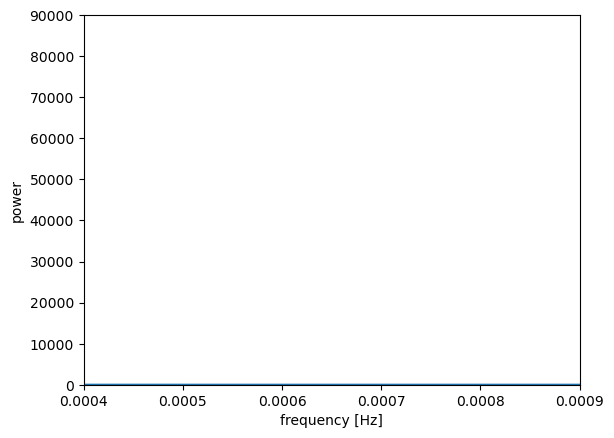

In [ ]:
dt = 60 # sampling rate in secs
ft = np.fft.rfft(power[0])
n = len(power[0])
freq = np.fft.rfftfreq(n, d=dt)

nyquist_frequency = 1/(2*dt)
ft_power = np.real(ft)*np.real(ft) + np.imag(ft)*np.imag(ft)

plt.plot(freq, ft_power)
plt.xlabel('frequency [Hz]')
plt.ylabel('power')
plt.xlim(0.0004, 0.0009)
plt.ylim(0,90000)
plt.show()

In [ ]:
peak = scipy.signal.find_peaks(ft_power, height=10000)
peak_width = scipy.signal.peak_widths(ft_power, peak[0], rel_height=0.5)

period = 1/(60*freq[peak[0][0]])
freq_err = peak_width[0]*(freq[1]-freq[0])
period_err = 1/(60*freq[peak[0][0]]**2)*freq_err

print(f'peak: {freq[peak[0][0]]} +/- {freq_err} Hz')
print(f'period: {period} +/- {period_err} mins')

IndexError: index 0 is out of bounds for axis 0 with size 0

Fourier analysis shows the same interferometer effect as predicted by PNW but with very large errors.
Could improve this with more time resolution.

Also a fun idea:
- remove the peak from the power spectra then ifft the data to obtain a cleaned transit

# (2) Finding FWHM

From ppt:
- differences in obs day accounted for by shifting and scaling amp
  - is this correct?
  - what if this has ignored a more fundamental issue?

- suggested solar flux variations not significant over transit
  - if they are how do we account for it?

- assumed the correction due to the Sun's transit not being flat is insignificant
  - if this is treated formally it may solve the discrepancy
  - has the movement of the Earth during the transit been accounted for?
    - obviously the rotation of Earth is the transit
    - but does its orbital motion need to be included too?
    - would this even been worthwhile doing? (too small an effect??)


## (2.1) scipy method (OLD)

These are functions for finding the fwhm which uses the find peaks method from scipy.

In [56]:
def harry_plotter_old(t, p, pk_loc, pk_h, l_loc, r_loc, h):
    plt.plot(t, p)
    plt.plot(t[pk_loc], pk_h, 'rx')
    plt.plot(t[0] + datetime.timedelta(minutes=l_loc[0]), h, 'gx')
    plt.plot(t[0] + datetime.timedelta(minutes=r_loc[0]), h, 'gx')

    plt.xlabel('time [mins]')
    plt.ylabel('power')
    plt.grid()
    #plt.show()
    return

In [8]:
def fwhm_analyser(t, p):
    pk_loc, pk_dic = scipy.signal.find_peaks(p, height=13, prominence=10) # prominence stops the detection of secondary peaks
    pk_h = pk_dic['peak_heights']
    print(f'peak index: {pk_loc}')
    #print(pk_dic)

    fwhm, fwhm_h, l_loc, r_loc = scipy.signal.peak_widths(p, pk_loc, rel_height=0.5) # finds the FWHM of the peak at peak_loc
    # fwhm is strictly the # of bins but as each is 1 min this is just the # of mins
    print(f'fwhm: {fwhm} mins')
    print(f'solar noon: {t[pk_loc[0]]}')
    print(f'left half max: {t[0] + datetime.timedelta(minutes=l_loc[0])}')
    print(f'right half max: {t[0] + datetime.timedelta(minutes=r_loc[0])}')

    harry_plotter_old(t, p, pk_loc, pk_h, l_loc, r_loc, fwhm_h)
    return fwhm

In [7]:
def harry_plotter_gauss(t, p, parameters):
    plt.plot(t, p)
    plt.plot(t, gaussian(t, *parameters))

    plt.xlabel('time [mins]')
    plt.ylabel('power')
    plt.grid()
    #plt.show()
    return

## (2.2) Gaussian Fitting

In [162]:
def gaussian(y, a, b, c, d):
    return a*np.exp(-((y-b)**2)/(2*(c/2.4)**2))+d

def gaussian_fitting(x, y):
    p0 = np.array([np.max(y), np.argmax(y), 98, 10])
    popt, pcov = scipy.optimize.curve_fit(gaussian, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

In [179]:
def line_fitting(x_data, y_data, y_uncertainties):

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights)**2)

    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights) - np.sum(x_data * weights) * np.sum(y_data * weights)) / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)

    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights) * np.sum(x_data * y_data * weights)) / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty, offset_uncertainty]))

In [163]:
print(time.shape)
print(power.shape)

#[print(type(line)) for line in time]
time_mins = [(t - time[0]).total_seconds() / 60 for t in time]


para, para_cov = gaussian_fitting(time_mins, power[0])
para_err = np.sqrt(np.diag(para_cov))
print(para)
print(para_err)

plt.plot(time_mins, power[0])
plt.plot(time_mins, gaussian(time_mins, *para))
plt.show()

fwhm_mins = para[2]
fwhm_mins_err = para_err[2]
print(f'fwhm: {fwhm_mins} +/- {fwhm_mins_err} mins')

plt.plot(time_mins, power[0]/gaussian(time_mins, *para))
#plt.title('Difference between observed power and the fitted gaussian.')
plt.xlabel('time [mins]')
plt.ylabel('ratio')
plt.grid()
plt.show()

(420,)
(4, 420, 718)


ValueError: operands could not be broadcast together with shapes (420,) (420,718) 

In [159]:
def calc_beam_width(t, p, dec):
    time_mins = [(i - t[0]).total_seconds() / 60 for i in t]

    para, para_cov = gaussian_fitting(time_mins, p)
    para_err = np.sqrt(np.diag(para_cov))
    
    fwhm_deg_temp = para[2]*np.cos(dec)*360/(23.9345*60)
    fwhm_deg_err_temp = para_err[2]*np.cos(dec)*360/(23.9345*60)

    peak = datetime.timedelta(minutes=para[1]) + t[0]
    peak_err = para_err[1]
    pointing_diff_mins = abs(peak-transit_total.noon).total_seconds()/60
    pointing_diff_temp = pointing_diff_mins*np.cos(sol_dec)*360/(23.9345*60)
    pointing_diff_err_temp = peak_err*np.cos(sol_dec)*360/(23.9345*60)

    #harry_plotter_gauss(time_mins, p, para)
    #plt.show()

    return fwhm_deg_temp, fwhm_deg_err_temp, pointing_diff_temp, pointing_diff_err_temp

Analysis of the full spectrum indicates that there is a slight frequency depedence on the beam width. It appears to increase with frequency by a factor of 0.0214

(420, 718)
(420,)
[ 0.02143161 -6.79392369]


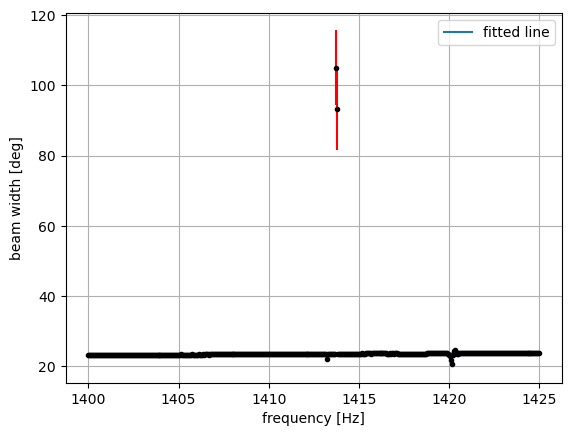

In [205]:
power2 = power[0]
print(power2.shape)
print(power2[:,0].shape)

sol_dec = transit.dec_mid*np.pi/180

fwhm_deg = np.array([]) # empty array to store the FWHM values
fwhm_deg_err = np.array([])
pointing_diff = np.array([])
pointing_diff_err = np.array([])

for i in range(112, 570):
    fwhm, fwhm_err,_,_ = calc_beam_width(time, power2[:,i], sol_dec)
    fwhm_deg = np.append(fwhm_deg, fwhm)
    fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)

freq = np.linspace(1400, 1425, 458)
plt.errorbar(freq, fwhm_deg, fwhm_deg_err, fmt='k.', ecolor='r')


#plt.plot(fwhm_deg)
#plt.xlim(1400, 1401)
#plt.ylim(23.1,23.8)


values, errors = line_fitting(freq, fwhm_deg, fwhm_deg_err)
print(values)
plt.plot(freq, values[0]*freq+values[1], label='fitted line')
plt.xlabel('frequency [Hz]')
plt.ylabel('beam width [deg]')
plt.legend()
plt.grid()

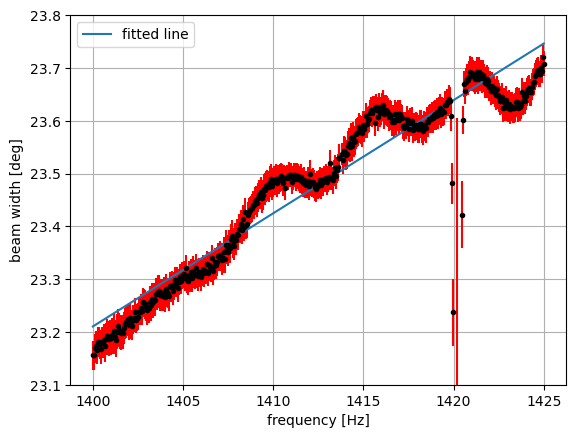

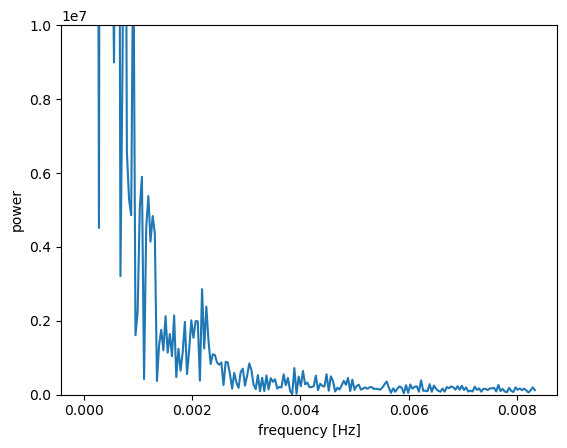

In [101]:
dt = 60 # sampling rate in 
# need a smaller sampling rate if we want to probe for greater frequencies as we are limited to 0.008 Hz here.

ft = np.fft.rfft(power2[:, 364])
n = len(power2[:,365])
freq = np.fft.rfftfreq(n, d=dt)

nyquist_frequency = 1/(2*dt)
ft_power = np.real(ft)*np.real(ft) + np.imag(ft)*np.imag(ft)

plt.plot(freq, ft_power)
plt.xlabel('frequency [Hz]')
plt.ylabel('power')
#plt.xlim(0.0002)
plt.ylim(0,1e7)
plt.show()

mean fwhm: 23.58119208112666 +/- 0.009987852924071346 deg


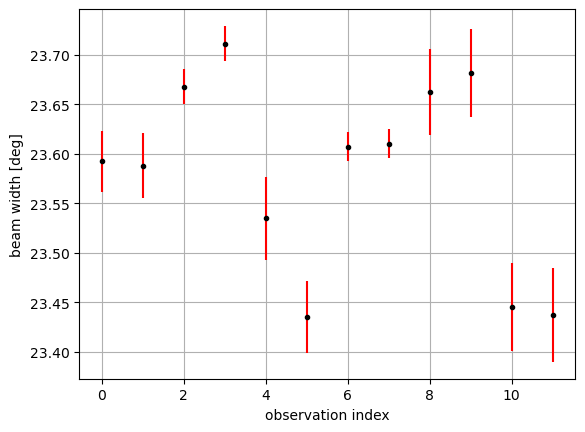

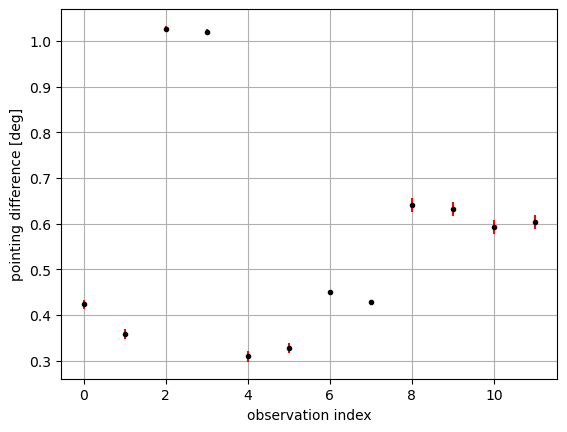

In [12]:
fwhm_deg = np.array([]) # empty array to store the FWHM values
fwhm_deg_err = np.array([])
pointing_diff = np.array([])
pointing_diff_err = np.array([])

for j in range(0,len(transit_total_list)-4):
    transit_total = transit_total_list[j]
    data = transit_total.get_data()
    time = data[0]
    power = data[1:]
    sol_dec = transit_total.dec_mid*np.pi/180
    for i in range(0,len(power)):
        fwhm, fwhm_err, pnt, pnt_err = calc_beam_width(time, power[i], sol_dec)
        fwhm_deg = np.append(fwhm_deg, fwhm)
        fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)
        pointing_diff = np.append(pointing_diff, pnt)
        pointing_diff_err = np.append(pointing_diff_err, pnt_err)
        # loops through each spectrometer output and calculates a FWHM adding it to an array

#print(fwhm_mins)
#print(fwhm_mins_err)
#print(pointing_diff)

mean_fwhm_deg = np.mean(fwhm_deg)
mean_fwhm_deg_err = (1/len(fwhm_deg_err))*np.sqrt(sum(fwhm_deg_err**2))

print(f'mean fwhm: {mean_fwhm_deg} +/- {mean_fwhm_deg_err} deg')

plt.errorbar(np.arange(0,len(fwhm_deg),1),fwhm_deg, fwhm_deg_err, fmt = 'k.', ecolor='r')
plt.xlabel('observation index')
plt.ylabel('beam width [deg]')
plt.grid()
plt.show()

plt.errorbar(np.arange(0,len(fwhm_deg),1), pointing_diff, pointing_diff_err, fmt='k.', ecolor='r')
plt.xlabel('observation index')
plt.ylabel('pointing difference [deg]')
plt.grid()
plt.show()

In [ ]:
HI_fwhm_deg = np.array([]) # empty array to store the FWHM values
HI_fwhm_deg_err = np.array([])
HI_noon = np.array([])
HI_pointing_diff = np.array([])
HI_pointing_diff_err = np.array([])

for j in range(0,len(HItransit_list)-2):
    HItransit = HItransit_list[j]
    data = HItransit.get_data()
    time = data[0]
    power = data[1:]
    time_mins = [(t - time[0]).total_seconds() / 60 for t in time]
    for i in range(0,len(power)):
        sol_dec = HItransit.dec_mid*np.pi/180
        para, para_cov = gaussian_fitting(time_mins, power[i])
        para_err = np.sqrt(np.diag(para_cov))
        #print(para_err[1])

        HI_fwhm_mins = para[2]
        HI_fwhm_mins_err = para_err[2]
        HI_fwhm_deg = np.append(HI_fwhm_deg, HI_fwhm_mins*np.cos(sol_dec)*360/(23.9345*60))
        HI_fwhm_deg_err = np.append(HI_fwhm_deg_err, HI_fwhm_mins_err*np.cos(sol_dec)*360/(23.9345*60))

        peak = datetime.timedelta(minutes=para[1]) + time[0]
        peak_err = para_err[1]
        HI_noon = np.append(noon, peak)
        HI_pointing_diff_mins = abs(peak-HItransit.noon).total_seconds()/60
        HI_pointing_diff = np.append(HI_pointing_diff, HI_pointing_diff_mins*np.cos(sol_dec)*360/(23.9345*60))
        HI_pointing_diff_err = np.append(HI_pointing_diff_err, peak_err*np.cos(sol_dec)*360/(23.9345*60))

        #harry_plotter_gauss(time_mins, power[i], para)
        plt.show()
        # loops through each spectrometer output and calculates a FWHM adding it to an array

#print(HI_fwhm_deg)
#print(HI_fwhm_mins_err)
#print(HI_noon)
#print(HI_pointing_diff)

HI_mean_fwhm_deg = np.mean(HI_fwhm_deg)
HI_mean_fwhm_deg_err = np.mean(HI_fwhm_deg_err)
print(f'mean fwhm: {HI_mean_fwhm_deg} +/- {HI_mean_fwhm_deg_err} deg')

plt.errorbar(np.arange(0,len(HI_fwhm_deg),1),HI_fwhm_deg, HI_fwhm_deg_err, fmt = 'k.', ecolor='r')
plt.xlabel('observation index')
plt.ylabel('beam width [deg]')
plt.grid()
plt.show()

HI_mean_pointing_diff = np.mean(HI_pointing_diff)
HI_mean_pointing_diff_err = 1/len(HI_pointing_diff_err)

plt.errorbar(np.arange(0,len(HI_fwhm_deg),1), HI_pointing_diff, HI_pointing_diff_err, fmt='k.', ecolor='r')
plt.xlabel('observation index')
plt.ylabel('pointing difference [deg]')
plt.grid()
plt.show()

In [13]:
fwhm_deg = np.array([]) # empty array to store the FWHM values
fwhm_deg_err = np.array([])
pointing_diff = np.array([])
pointing_diff_err = np.array([])

for k in range(0,len(transit_list)):
    transit = transit_list[k]
    time, power_array = transit.get_data()
    sol_dec = transit.dec_mid*np.pi/180
    for j in range(0, len(power_array[0])):
        power_all_freq = power_array[j,:,:]
        for i in range(0,len(power)):
            fwhm, fwhm_err, pnt, pnt_err = calc_beam_width(time, power[i], sol_dec)
            fwhm_deg = np.append(fwhm_deg, fwhm)
            fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)
            pointing_diff = np.append(pointing_diff, pnt)
            pointing_diff_err = np.append(pointing_diff_err, pnt_err)

print(fwhm_deg.shape)

['a1p1_bandpass.npy', 'a1p2_bandpass.npy', 'a2p1_bandpass.npy', 'a2p2_bandpass.npy', 'datetimes.npy']


ValueError: operands could not be broadcast together with shapes (420,) (343,) 

## (2.3) Gaussian Test

I should plot a gaussian using the same peak and width to see if it shows and differences past the FWHM. We expect to see a sharper cutoff than expected for a gaussian distribtuion due to the slightly curved transit.

In [ ]:
'''
def gaussian(x, a, b, c):
    return a*np.exp(-((x-b)**2)/(2*(c/2.4)**2)) # 18 needs a shift of 2, 21 need a shift of 0

plt.plot(time_norm, gaussian(time_norm, peak_dic['peak_heights'][0], time_norm[peak_loc], fwhm_mins))
plt.plot(time_norm, power)
plt.show()

plt.plot(time_norm, abs(power-gaussian(time_norm, peak_dic['peak_heights'][0], time_norm[peak_loc], fwhm_mins)))
plt.vlines(time_norm[0]+left_loc, 0,0.35,'r','--')
plt.vlines(time_norm[0]+right_loc, 0,0.35,'r','--')
plt.show()
'''

Plotting a gaussian with the same peak (slightly shifted to line up better) and FWHM appears to have a sharper drop-off. Why?

This could be that as the real data drops off faster than we would expect from a standard gaussian, the FWHM it provides actually yields a gaussian which drops off faster than the data. I'm not sure if this is correct though I can't fully justify it.

# (3) Mins to Deg conversion

It takes approx. 24 hours to travel around the great circle. In reality need siderial day which increases the FWHM by approx. 0.06 deg. But this assumes we are at 0 dec. Since we are not a correction is applied of cos(dec).

In [ ]:
sol_dec = transit.dec_mid # declination of Sun according to NOAA [in deg]
# this uses a rough set of coords from google maps [53.234339, -2.305022] - NEED TO GET ACTUAL COORDS!!!
# coords from PNW: [53.2344, -2.3050]
sol_dec = sol_dec*np.pi/180 # convert to radians

fwhm_deg = fwhm_mins*np.cos(sol_dec)*360/(23.9345*60)
print(f'fwhm: {fwhm_deg} deg')

In [ ]:
angle_test_deg = 6
angle_test_mins = angle_test_deg*(23.9345*60)/(360*np.cos(sol_dec))
print(angle_test_mins)

time_test_mins = 0.05
time_test_deg = time_test_mins*np.cos(sol_dec)*360/(23.9345*60)
print(time_test_deg)

In [ ]:
period_deg = period*np.cos(sol_dec)*360/(23.9345*60)
print(f'period: {period_deg} deg')

This FWHM isn't exactly the beam width as it ignores that the solar transit isn't a straight line across the beam.

In [ ]:
theta = sol_dec - (transit.dec_L*np.pi/180)
print(f'theta: {theta}')

beam_width = fwhm_deg/np.cos(theta) # fwhm should be halved but this is cancelled when doubling to get beam width
print(f'beam width: {beam_width} deg')

change = beam_width - fwhm_deg
print(f'change: {change} deg')

Taking into account the curved path of the Sun's transit changes the fwhm by approx. 1e6 deg so is entirely negligible.

However, this still ignores further issues with the spherical geometry of the transit:
- if it is over approx. 23 deg of rotation then there is enough curvature that the time spent in the beam is LONGER than if we treat this as a 2D problem.
- whilst this should be a simple fix to a straight transit line, how do we apply this to the curved path?
  - do we apply this fix first then the curved path??

This might not be correct:
- if we are using units of deg for the beam width then maybe this already accounts for the 3D curvature.

In [ ]:
print(1-np.cos(0.1*np.pi/180))

# (4) Australian Data
I want to plot the data from the Australian observatory on the 24th and 25th of June 2024 to see if they see the same oscillation as us.

It would also be good to repeat this for the Belgium observatory.

In [ ]:
aus_data = np.genfromtxt(os.path.join(pathtemplate, 'Data/AUS_24_06_2024.txt'), usecols=(0,4), skip_header=22000, skip_footer=62000) # solar flux measured every second in 1415 MHz
plt.plot(aus_data[:,0]/60, aus_data[:,1])
plt.xlabel('time [mins]')
plt.ylabel('solar flux')
plt.show()

# (5) Belgium Data
Need to plot the observation from the 24/06/2024 to see if they also saw the proposed SRB.

In [206]:
import astropy.io.fits as pf
filenames = ['HUMAIN_20240624070000i_60.fit', 'HUMAIN_20240624100000i_60.fit', 'HUMAIN_20240624130000i_60.fit']


for name in filenames:
    hdu = pf.open(os.path.join(pathtemplate,'Data/',name))
    data = hdu[0].data
    anc = hdu[1].data
    time = anc['TIME']
    time = time[0]
    freq = anc['FREQUENCY']
    freq = freq[0]

    ok = np.where((freq>=1400)&(freq<1427))
    plt.plot(time/3600, np.median(data[ok[0],:],axis=0),'.')# to remove interferences (spikes)

plt.xlim(11.5, 12.5)
plt.ylim (-108, -104)
plt.xlabel('UTC [hours]')
plt.ylabel('solar flux')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/jetso/Creative Cloud Files/Desktop/Uni/L-BASS\\Data/HUMAIN_20240624070000i_60.fit'

# Test Space

In [ ]:
# does scaling the amp of a gaussian affect the FWHM?
a = 10
b = 0
s = 10


x = np.arange(-100,100,1)
y = a*np.exp(-((x-b)**2)/(2*s**2))
scaled_y = 3*a*np.exp(-(x**2)/(2*s**2))


plt.plot(x,y, label='1')
plt.plot(x,scaled_y, label='2')
plt.legend()

scipy.signal.find_peaks(y, )